Haussdorf Metrics and Loss Function
====
Using the Haussdorf distance we can hopefully improve our image segmentation algorithms.

The Haussdorf distance between two objects is defined as the maximum shortest distance from one object to another: this isn't a very helpful definition, so a diagram is helpful:

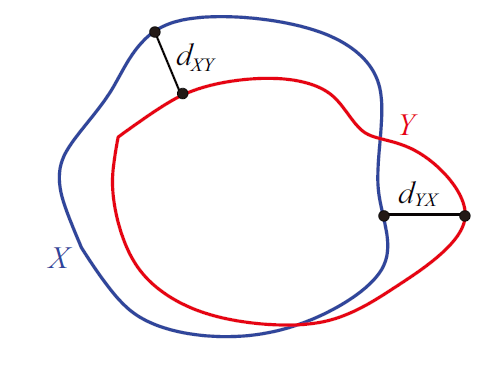

In [14]:
from PIL import Image

Image.open("img/haussdorf.png")

If we choose any point on X, we can find the shortest distance to Y; by choosing the right point on X, we can find the largest such distance ($d_{XY}$).
Similarly, we can find the greatest shortest distance from Y to X ($d_{YX}$).
The Haussdorf distance is defined as the greatest of these two distances.

It is a useful metric because it encapsulates our intuitive idea of "closeness".

For objects in 2d, we can work out the Haussdorf distance...

In [15]:
"""
Create two binary images, x and y, and calculate the Hausdorff distance between them.

"""
from typing import Union, Iterable

import numpy as np
from scipy import ndimage
from skimage import metrics
import matplotlib.pyplot as plt

IMG_SIZE = (256, 192)
RNG = np.random.default_rng(seed=0)


def gaussian_image(
    *, centre: tuple[int, int], sigma: Union[float, Iterable[float]]
) -> np.ndarray:
    """
    Binary image generated from a Gaussian, centred on the image centre

    """
    # Zeros with a 1 in the middle
    arr = np.zeros(IMG_SIZE)
    arr[centre] = 1

    # Apply a Gaussian filter to this 1 to spread it out
    arr = ndimage.gaussian_filter(arr, sigma=sigma)

    # Scale
    arr = arr / arr.max()
    arr = arr > 0.5

    return arr.astype(int)


# Define the two images
x_centre = (IMG_SIZE[0] // 3, IMG_SIZE[1] // 3)
hard_x = gaussian_image(centre=x_centre, sigma=IMG_SIZE[0] // 8)

y_centre = (IMG_SIZE[0] // 2, 2 * IMG_SIZE[1] // 5)
y = gaussian_image(centre=y_centre, sigma=[IMG_SIZE[0] // 4, IMG_SIZE[1] // 7])

# Find the Hausdorff distance between them
distance = metrics.hausdorff_distance(hard_x, y)

# For plotting, we'll also want to find the points that this corresponds to
haussdorf_points = metrics.hausdorff_pair(hard_x, y)

Text(0.5, 1.0, 'The Hausdorff distance is longest minimal distance between X and Y')

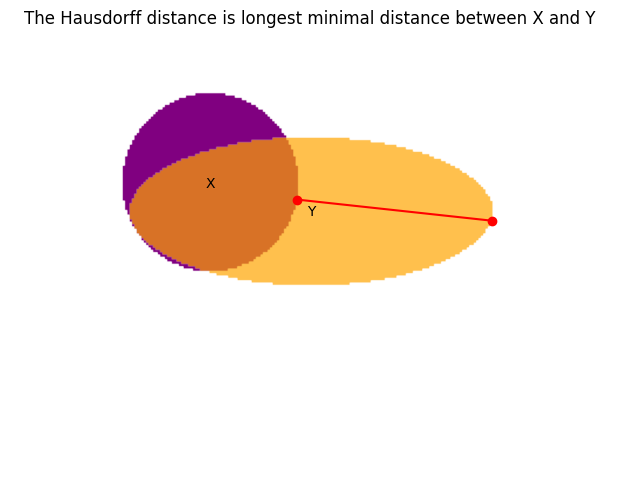

In [16]:
from matplotlib import colors


def plot_objects(
    obj_x: np.ndarray, obj_y: np.ndarray, *, xlabel: str = "X", ylabel: str = "Y"
) -> tuple[plt.Figure, plt.Axes]:
    """
    Plot two binary objects located at x

    """
    fig, axis = plt.subplots(1, 1)
    axis.set_aspect("equal")

    # Colormaps should go from transparent to a colour
    def _transparent_cmap(colour_name: str) -> colors.LinearSegmentedColormap:
        """Smoothly go from transparent to a colour"""
        return colors.LinearSegmentedColormap.from_list(
            "", [(0, (1, 1, 1, 0)), (1, colors.to_rgba(colour_name))]
        )

    axis.imshow(obj_x.T, alpha=1.0, origin="upper", cmap=_transparent_cmap("purple"))
    axis.imshow(obj_y.T, alpha=0.7, origin="upper", cmap=_transparent_cmap("orange"))

    # Label the objects
    axis.text(*x_centre, xlabel, ha="center", va="center", color="black")
    axis.text(*y_centre, ylabel, ha="center", va="center", color="black")

    axis.axis("off")

    fig.tight_layout()

    return fig, axis


fig, axis = plot_objects(hard_x, y)

# Plot the Hausdorff distance
hausdorff_x, hausdorff_y = zip(*haussdorf_points)
axis.plot(hausdorff_x, hausdorff_y, "ro-")

axis.set_title(f"The Hausdorff distance is longest minimal distance between X and Y")

A complication for segmentation problems
----
Unfortunately, when we train a model to segment an image it does not give us a prediction of a neatly segmented object with a hard boundary - instead, it gives us a floating point number for each pixel that tells us how confident it is about its prediction.

This makes training the model easier - if it were to give a hard prediction, it would likely be unable to learn as the loss function would have zero gradients, with sharp steps in the loss as it guesses the correct position of the object.

It also, however, makes evaluating the Hausdorff distance more difficult as this is only defined for objects with hard boundaries:

In [17]:
"""
Show a fuzzy prediction against the hard ground truth

"""
fuzzy_x = ndimage.gaussian_filter(hard_x.astype(np.float32), sigma=IMG_SIZE[0] // 64)

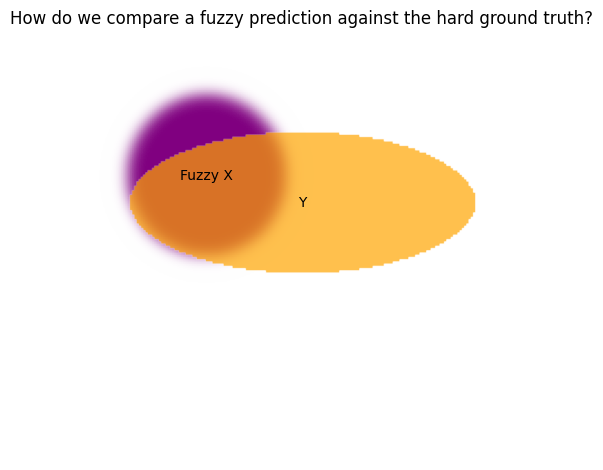

In [18]:
fig, axis = plot_objects(fuzzy_x, y, xlabel="Fuzzy X")

axis.set_title("How do we compare a fuzzy prediction against the hard ground truth?")
fig.tight_layout()

Approximation to the Hausdorff Distance
----

We must instead make an approximation to the Hausdorff distance.
We can do this using the Euclidean distance transform - this tells us the distance from each pixel in Y from the nearest background pixel.

In [26]:
"""
Show the Euclidean distance transform

"""

from scipy.ndimage import distance_transform_edt


def external_distance_field(arr: np.ndarray) -> np.ndarray:
    return distance_transform_edt(1 - arr)


def internal_distance_field(arr: np.ndarray) -> np.ndarray:
    return distance_transform_edt(arr)


external_y = external_distance_field(y)
internal_y = internal_distance_field(y)

Text(0.5, 1.0, 'Internal')

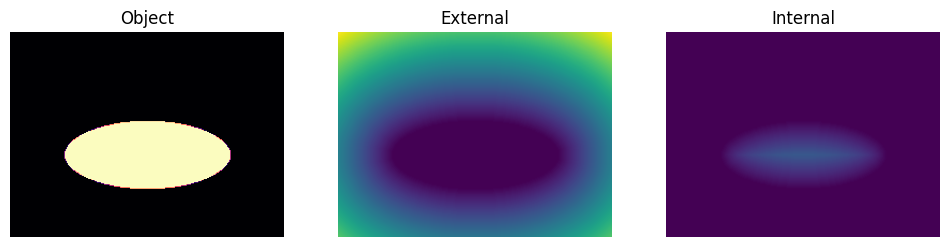

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for axis in axes:
    axis.set_axis_off()

plot_kw = {"origin": "lower", "cmap": "magma"}
axes[0].imshow(y.T, **plot_kw)

plot_kw["cmap"] = "viridis"
plot_kw["vmin"] = 0
plot_kw["vmax"] = max(external_y.max(), internal_y.max())
axes[1].imshow(external_y.T, **plot_kw)
axes[2].imshow(internal_y.T, **plot_kw)

axes[0].set_title("Object")
axes[1].set_title("External")
axes[2].set_title("Internal")

These distance fields give us information about how far the our prediction is away from the object.  
Now, in order to find a metric that is interpretable as the Hausdorff distance, we need to add awareness of where our prediction is.  
If we had a hard prediction, we could just check all the pixels in our prediction and find the maximum value of the distance field: 

In [35]:
"""
Find the Hausdorff distance between two objects, and also show the distance transform masked by the hard object

"""

total_distance_field = external_distance_field(y) + internal_distance_field(y)
masked_distance_field = np.where(hard_x, total_distance_field, 0)

Text(0.5, 1.0, 'Masked distance field')

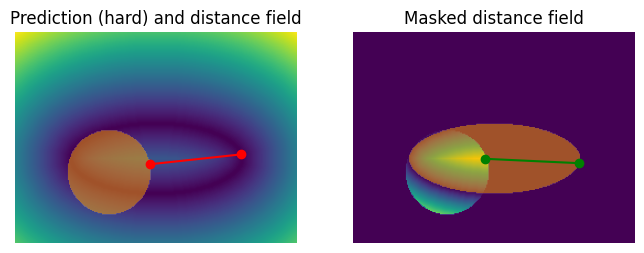

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))


def transparent_cmap(colour_name: str) -> colors.LinearSegmentedColormap:
    """Smoothly go from transparent to a colour"""
    return colors.LinearSegmentedColormap.from_list(
        "", [(0, (1, 1, 1, 0)), (1, colors.to_rgba(colour_name))]
    )


for axis in axes:
    axis.set_axis_off()

plot_kw = {"origin": "lower", "aspect": "equal"}

# Plot the distance field and the object
axes[0].imshow(total_distance_field.T, **plot_kw)
axes[0].imshow(hard_x.T, cmap=transparent_cmap("orange"), **plot_kw, alpha=0.5)

# Plot the Hausdorff points for the hard object and the ground truth
axes[0].plot(hausdorff_x, hausdorff_y, "ro-")


# Plot the masked distance field
axes[1].imshow(masked_distance_field.T, **plot_kw)
axes[1].imshow(y.T, cmap=transparent_cmap("orange"), **plot_kw, alpha=0.5)

# Plot the maximum distance in the masked field, and the corresponding furthest point from the ground truth


def furthest_point(arr: np.ndarray, point: tuple[int, int]) -> tuple[int, int]:
    """
    The furthest point in the binary array from a given point

    """
    assert set(np.unique(arr)) <= {0, 1}

    # Convert the True points in the array to coordinates
    coords = np.argwhere(arr)

    # Find the distance between the point and all the other points
    distances = np.linalg.norm(coords - point, axis=1)

    # Find the index of the maximum distance
    max_dist = distances.argmax()

    return tuple(coords[max_dist])


def max_location(arr: np.ndarray) -> tuple[int, int]:
    """
    The location of the maximum value in an array

    """
    max_idx = np.unravel_index(arr.argmax(), arr.shape)
    return tuple(max_idx)


max_loc = max_location(masked_distance_field)
furthest = furthest_point(y, max_loc)
axes[1].plot(*zip(furthest, max_loc), "go-")

axes[0].set_title("Prediction (hard) and distance field")
axes[1].set_title("Masked distance field")

We can then take the product of the Euclidean distance transform and the fuzzy prediction to get a measure of how well the objects overlap.
This will weight pixels in the centre of the ground truth more highly, giving the function some spatial awareness of where the centre of the object is, as well as gradient information that can be used by a model for learning.

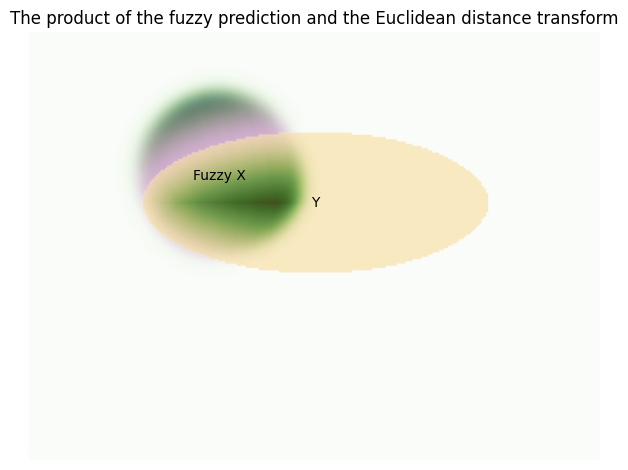

In [8]:
"""
Product of prediction and the EDT

"""

product = fuzzy_x * y_edt

fig, axis = plot_objects(fuzzy_x, y, xlabel="Fuzzy X")

axis.imshow(product.T, alpha=0.7, origin="upper", cmap="Greens")
axis.set_title(
    "The product of the fuzzy prediction and the Euclidean distance transform"
)

fig.tight_layout()

We can then take the maximum, mean or sum of this product and hopefully one of them will tell us something about the overlap of the objects...

In [9]:
"""
Create an animation showing the fuzzy prediction moving around, and how it affects the maximum, mean and sum of the product

"""

cmap_x = colors.LinearSegmentedColormap.from_list(
    "", [(0, (1, 1, 1, 0)), (1, colors.to_rgba("purple"))]
)
cmap_y = colors.LinearSegmentedColormap.from_list(
    "", [(0, (1, 1, 1, 0)), (1, colors.to_rgba("orange"))]
)
cmap_prod = colors.LinearSegmentedColormap.from_list(
    "", [(0, (1, 1, 1, 0)), (1, "green")]
)

Text(0.5, 1.0, 'Path of object')

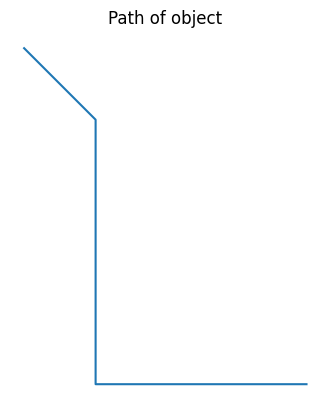

In [10]:
"""
Choose a path for the object to take

"""

# Path that goes diagonal
x_positions = list(
    zip(np.arange(50, IMG_SIZE[0] - 50), np.arange(50, (IMG_SIZE[1] - 50) // 2))
)
x_sigma = [(IMG_SIZE[0] // 8, IMG_SIZE[0] // 8)] * len(x_positions)

# Path that goes down and dilates the object
n = 75
x_positions += [(x_positions[-1][0] + i, x_positions[-1][1]) for i in range(n)]
x_sigma += [((1 + i / n) * IMG_SIZE[0] // 8, IMG_SIZE[0] // 8) for i in range(n)]

# Path that goes across
n = 60
x_positions += [(x_positions[-1][0], x_positions[-1][1] + i) for i in range(n)]
x_sigma += [x_sigma[-1]] * n

# y doesn't move (it corresponds to the ground truth)
y_centre = (IMG_SIZE[0] // 2, 2 * IMG_SIZE[1] // 5)
y_sigma = [IMG_SIZE[0] // 4, IMG_SIZE[1] // 7]

fig, axis = plt.subplots()
# This munging just gives the right orientation of the path wrt the image that we'll plot later
axis.plot([i[1] for i in x_positions], [-i[0] for i in x_positions])
axis.set_aspect("equal")
axis.axis("off")
axis.set_title("Path of object")


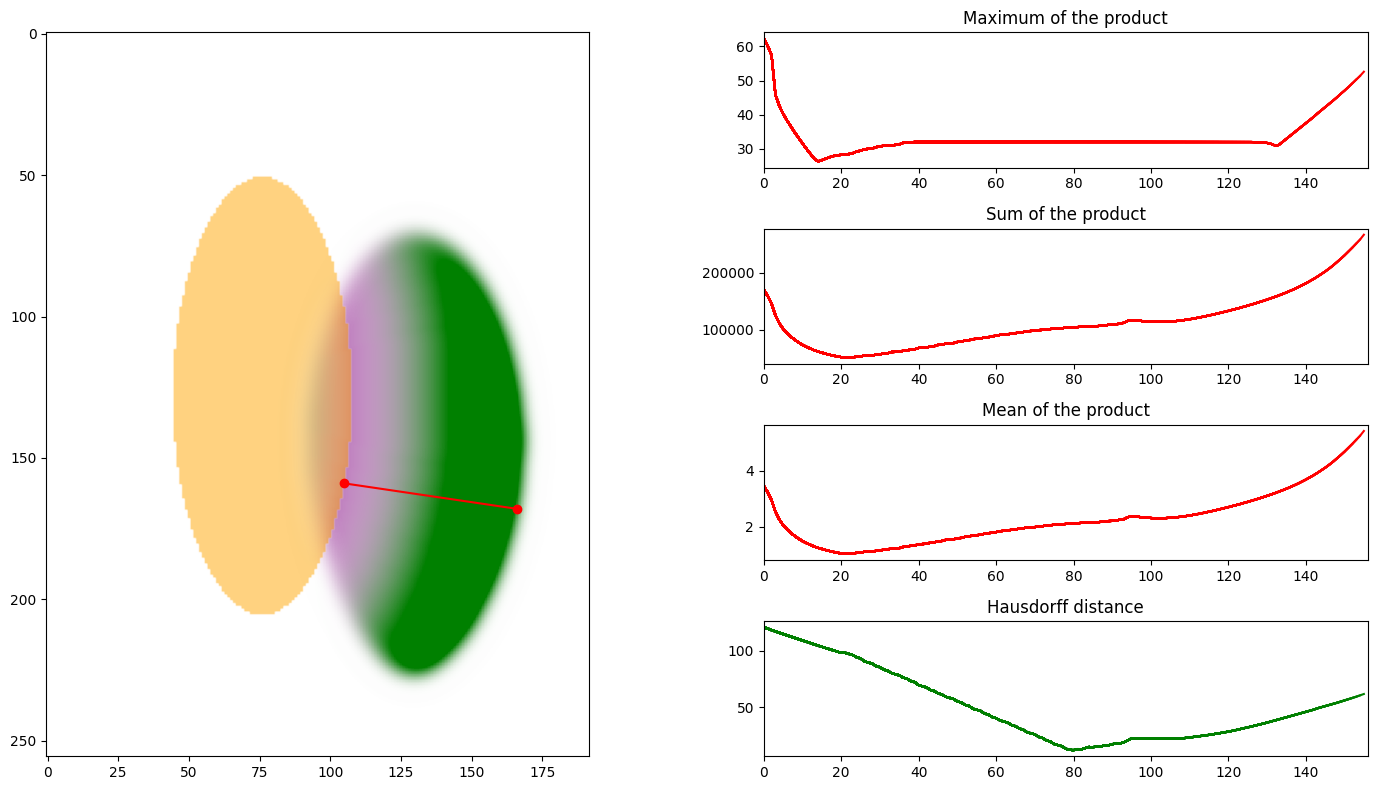

In [11]:
"""
Create an Animation object

"""

from matplotlib.animation import FuncAnimation

fig, axes = plt.subplot_mosaic(
    """
    AAABBB
    AAACCC
    """,
    figsize=(15, 8),
)
axes["A"].set_aspect("equal")
axes["A"].axis("off")

axes["B"].set_title("Maximum of the product")
axes["C"].set_title("Sum of the product")

fig.tight_layout()

h_dists = []
sums = []
maxes = []
means = []
idx = []


for labels in "BCDE":
    axes[labels].set_xlim(0, len(x_positions))


def animate(i):
    """
    Very slow because idc about it being very slow

    """
    idx.append(i)

    # Create an object at this position
    hard_x = gaussian_image(centre=x_positions[i], sigma=x_sigma[i])

    fuzzy_x = ndimage.gaussian_filter(
        hard_x.astype(np.float32), sigma=IMG_SIZE[0] // 64
    )

    # Calculate the product of the fuzzy prediction and the Euclidean distance transform
    prod = fuzzy_x * edt(y)

    # Calculate the Hausdorff distance and points
    h_dist = metrics.hausdorff_distance(hard_x, y)

    h_points = metrics.hausdorff_pair(hard_x, y)
    hausdorff_x, hausdorff_y = zip(*h_points)

    sums.append(prod.sum())
    maxes.append(prod.max())
    means.append(prod.mean())
    h_dists.append(h_dist)

    axes["A"].cla()
    x_im = axes["A"].imshow(fuzzy_x, origin="upper", cmap=cmap_x, alpha=0.5)
    y_im = axes["A"].imshow(y, origin="upper", cmap=cmap_y, alpha=0.5)
    axes["A"].plot(hausdorff_y, hausdorff_x, "ro-")

    vmax = 35
    prod_im = axes["A"].imshow(
        prod, origin="upper", cmap=cmap_prod, alpha=1.0, vmax=vmax
    )

    (max_im,) = axes["B"].plot(idx, maxes, "r-")
    (sum_im,) = axes["C"].plot(idx, sums, "r-")
    (mean_im,) = axes["D"].plot(idx, means, "r-")

    (h_im,) = axes["E"].plot(idx, h_dists, "g-")

    return x_im, y_im, prod_im, max_im, sum_im, mean_im, h_im


anim = FuncAnimation(fig, animate, frames=len(x_positions), interval=24, blit=True)
anim.save("img/fuzzy_prediction.mp4")

In [12]:
def approx_hausdorff(prediction: np.ndarray, truth: np.ndarray) -> float:
    """
    Approximate Hausdorff distance between an image (prediction) and a binary image (truth)

    """
    assert prediction.shape == truth.shape
    assert set(np.unique(truth)) == {True, False}

    # Find the distance map
    distmap = distance_transform_edt(1 - truth) + distance_transform_edt(truth)

    # Find the product of the prediction and the distance map
    prod = prediction * distmap

    return np.mean(prod)